# GEO877: Spatial Algorithms - Haklay - Preprocessing



## Introduction

In Haklay paper, a comparison has been made between OSM dataset and official datasets from the UK. To reproduce it for Switzerland, we have decided to compare OSM with ASTRA.

In [1]:
from geospatial import *
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, mapping, MultiLineString
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

## Classes and functions

In [2]:
# Define class to store attributes with each motorway segment
class MotorwaySegment(Segment):
    def __init__(self, start, end, name=str(), origin_name=str(), source=str(), crs=str()):
        super().__init__(start, end)
        self.name = name
        self.origin_name = origin_name
        self.source = source
        self.crs = crs
    
    # Overwrite representation
    def __repr__(self):
        return f'MotorwaySegment of "{self.name}" with start {self.start} and end {self.end}.' 
    
    def plot_seg(self, ax = None, color = 'blue', linewidth = 1, label = 'segments'):
        xs = [self.start.x, self.end.x]
        ys = [self.start.y, self.end.y]
        if ax:
            ax.plot(xs, ys, color = color, linewidth = linewidth, label=label)
        else:
            plt.plot(xs, ys, color = color, linewidth = linewidth, label=label)

        
def linestring_to_coords(line):
    """ 
    !Requires shapely.geometry.mapping()!
    https://stackoverflow.com/questions/62053253/how-to-split-a-linestring-to-segments
        
    Creates a tuple of tuples containing x-, y-coordinates from a shapely.geometry.LineString() object.
    """
    # Create dictionary of attributes of LineString object
    mp = mapping(line)
    # Extracts coordinate tuples into a list
    t_tuples = mp['coordinates']
    return t_tuples

def coords_to_point_list(coords):
    """
    Creates list of list of geospatial.Point() objects pairs from coord list.
    """
    point_list = []
    for coord_pair in coords:
        point_list.append(Point(coord_pair[0], coord_pair[1]))
    return point_list

In [3]:
# Transformation function based on pyproj Transformer
from pyproj import Transformer

def transform_segments(segments, from_crs='epsg:4326', to_crs='epsg:2056'):
    transformer = Transformer.from_crs(from_crs, to_crs)
    transformed_segments = []
    for segment in segments:
        start = segment.start
        end = segment.end
        name = segment.name
        source = segment.source
        crs = segment.crs
        start_transformed = transformer.transform(start.y, start.x)
        end_transformed = transformer.transform(end.y, end.x)
        transformed_segment = MotorwaySegment(Point(*start_transformed), Point(*end_transformed), name, source, to_crs)
        transformed_segments.append(transformed_segment)
    return transformed_segments

In [4]:
class MotorwayLine():
    #initialise
    def __init__(self, data=None, xcol=None, ycol=None): #data = list of segments from the same street
        self.segments = []
        self.name = data[0].name
        self.points = []
        self.points_x = [] #to test
        self.points_y = [] #to test
        
        for d in data:
            #add segment
            self.segments.append(d)
            #add points - there will be duplicates /!\
            self.points.append(d.start)
            self.points.append(d.end)
            self.points_x.append(d.start.x)
            self.points_x.append(d.end.x)
            self.points_y.append(d.start.y)
            self.points_y.append(d.end.y)
            
            
    
    def __len__(self):
        return len(self.segments)
    
    def removeDuplicates(self):
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points)) # Get rid of the duplicates
        n = len(self.points)
        print(f'The old line had {oldn} points, now we only have {n}.')
        return self
        
    
    def bbox(self):
        x = [i.x for i in self.points]   # extract all x coords as a list
        y = [i.y for i in self.points]   # extract all y coords as a list

        # determine corners, calculate centre and area
        self.ll = Point(min(x), min(y))    # lower-left corner (min x, min y)
        self.ur = Point(max(x), max(y))    # upper-right corner (max x, max y)
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)   # centre of box
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    # area of box
        print(f'Bounding box with lower-left {self.ll} and upper-right {self.ur}' )
        return self.ll, self.ur
    
    def plot_bbox(self):
        ll, ur = self.bbox()
        plt.plot([ll.x, ll.x, ur.x, ur.x, ll.x], [ll.y, ur.y, ur.y, ll.y, ll.y], linestyle='dashed')

    def plot_seg(self, ax = None, color = 'blue', linewidth = 1, label = 'segments'):
        for seg in self.segments:
            seg.plot_seg(ax = ax, color = color, linewidth = linewidth, label = label)
    
    def plot_seg2(self):
        xs = []
        ys = []
        for seg in self.segments:
            xs.append(seg.start.x)
            xs.append(seg.end.x)
            ys.append(seg.start.y)
            ys.append(seg.end.y)

        plt.plot(xs, ys)
        
        
     # Overwrite representation
    def __repr__(self):
        return f'MotorwayLine "{self.name}" has "{len(self.segments)}" segments, and "{len(self.points)}" points.'    


#exemple_line = MotorwayLine([motorway_ch_segments[0], motorway_ch_segments[1]])
#print(exemple_line)
#exemple_line.removeDuplicates()
#exemple_line.bbox()
#exemple_line.plot_seg()
#exemple_line.plot_bbox()

## OSM

### Download data

<AxesSubplot:>

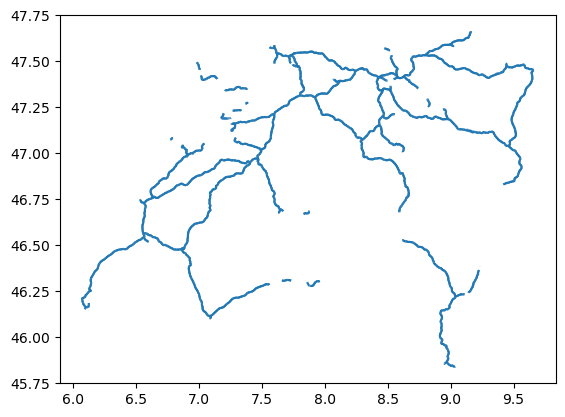

In [5]:
# Download OSM Data to GeoDataFrame()
tags = {"highway":"motorway"}
motorway_file_path = Path(r"./data/motorways_osm.geojson")
if motorway_file_path.is_file():
    motorways = gpd.read_file(motorway_file_path)
else:
    # Use ox package to download geometries from
    import osmnx as ox
    motorways = ox.geometries_from_place("Switzerland",tags=tags)
    # Convert lists to strings for GeoJSON
    motorways = motorways.apply(lambda col: col.astype(str) if isinstance(col[0], list) else col)
    motorways.to_file(motorway_file_path, "GeoJSON")
motorways.plot()

### Data filtering
To have the same data as in ASTRA, some filter has to be applied.

Some highways collected in OSM are not taken care by ASTRA, but by cantons. They are therefore not in ASTRA datasets and were discarded ("A50" and "A51").
Subsections of the highway "A1" ("A1a", "A1H", "A1R", "A1L", "A3W"), are not represented in the ASTRA data, and were therefore discarded.  
"A24" was also discarded as it is a road feeder and was normally not represented in OSM like the other road feeders.


In [6]:
#Remove unwanted segments
discard_list = ["A1a", "A1H", "A1R","A1R;5", "A1L", "A3W", "A24", "A50", "7;A50", "A51"]
filter_osm = ~motorways.ref.isin(discard_list)
motorways = motorways[filter_osm]
motorways = motorways[motorways['ref'].notna()]
streetnames_osm_toclean = motorways.ref.unique()
print(streetnames_osm_toclean)
print(len(streetnames_osm_toclean))

['A2' 'A9;A 2' 'A9' 'A13' 'A4' 'A1;A4' 'A3' 'A15' 'A14' '53' 'A1' 'A11'
 'A7' 'A23' 'A3;A4' 'A1;A2' '32' 'A1;A3' 'A1;A6' 'A6' 'A8' 'A12' 'A16'
 'A5' 'A22' 'A18' 'A2;A3' 'A21' 'A1;A9' 'A20' 'A20;20' 'A 16']
32


### Roads renaming
As OSM data is not rigorious, some corrections had to be made on the name registered. Visual data inspection was required for some cryptic names ("32", "52", "nan", ...). Then, only the number of the road has been kept.  
Example of corrections: "A 12" -> "A12", "A10;7" -> "A10", "53" -> "A15".


In [7]:
def name_mapping(in_name):
    #special cases, checked on QGIS:
    if in_name == "32":
        return 3
    elif in_name == "53":
         return 15
    elif in_name == "A9;A 2":
        return 2
    elif in_name == "A1;A4":
        return 1
    elif in_name == "A1;A4":
        return 1
    elif in_name == "A3;A4":
        return 3
    elif in_name == "A1;A2":
        return 1
    elif in_name == "A1;A3":
        return 1
    elif in_name == "A1;A6":
        return 1
    elif in_name == "A2;A3":
        return 2
    elif in_name == "A1;A9":
        return 1
    elif in_name == "A20;20":
        return 20
    
    #correct cases:
    elif ";" not in in_name:
        return int(''.join(filter(str.isdigit, in_name)))
    
    #catch new roads names
    else:
        print(in_name)
        print("Name not treated")

#build streetnames_osm list
streetnames_osm = []
for street in streetnames_osm_toclean:
    re = name_mapping(street)
    if re not in streetnames_osm:
        streetnames_osm.append(re)

print(sorted(streetnames_osm))
print(len(streetnames_osm))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23]
20


### Class MotorwaySegment

In [8]:
mway_geometries = motorways.geometry
nested_coords = [linestring_to_coords(line_geom) for line_geom in mway_geometries if type(line_geom)==type(LineString())]
nested_points = [coords_to_point_list(coord_list) for coord_list in nested_coords]
motorways["points"] = nested_points

motorway_segments = []
for index, row in motorways.iterrows():
    name = name_mapping(row['ref'])
    name_origin = row['ref']
    points = row['points']
    for i in range(len(points)-1):
        start = points[i]
        end = points[i+1]
        source = "osm"
        crs = 'epsg:4326'
        segment = MotorwaySegment(start, end, name, name_origin, source, crs)
        motorway_segments.append(segment)

In [9]:
# Example 4326 to 2056
motorway_segments_transformed = transform_segments(motorway_segments,
                                                   from_crs='epsg:4326', to_crs='epsg:2056')
print(f"{motorway_segments[0]} \t {motorway_segments[0].crs}",
      f"{motorway_segments_transformed[0]} \t {motorway_segments_transformed[0].crs}", sep="\n")

MotorwaySegment of "2" with start Point(x=8.9287827, y=46.0685891) and end Point(x=8.928685, y=46.0680586). 	 epsg:4326
MotorwaySegment of "2" with start Point(x=2715295.589739048, y=1102990.6704969718) and end Point(x=2715289.151463621, y=1102931.5637740807). 	 


### Class MotorwayLine

In [10]:
motorway_osm_lines = []
for streetname in streetnames_osm:
    list_segments = []
    for segment in motorway_segments_transformed:
        #find all segments of the streetname and put them in a list
        if segment.name == streetname:
            list_segments.append(segment)
    if len(list_segments) > 0:
        #create the line from the list
        motorwayLine = MotorwayLine(list_segments)
        #add the street to the motorway_lines dataset
        motorway_osm_lines.append(motorwayLine)    
        
#sort by order
motorway_osm_lines = sorted(motorway_osm_lines, key=lambda x: x.name)

print(motorway_osm_lines[0])
print(motorway_osm_lines[0].segments[0].origin_name)
len(motorway_osm_lines)

MotorwayLine "1" has "17254" segments, and "34508" points.
osm


20

### Data exploration

In [11]:
motorway_osm_lines[0].segments[0:10]

[MotorwaySegment of "1" with start Point(x=2687860.685738932, y=1251403.8349295186) and end Point(x=2687741.0563566852, y=1251395.5229915446).,
 MotorwaySegment of "1" with start Point(x=2687741.0563566852, y=1251395.5229915446) and end Point(x=2687600.256115355, y=1251389.0129866228).,
 MotorwaySegment of "1" with start Point(x=2687600.256115355, y=1251389.0129866228) and end Point(x=2687536.1658438644, y=1251388.1097729586).,
 MotorwaySegment of "1" with start Point(x=2687536.1658438644, y=1251388.1097729586) and end Point(x=2687491.2416364234, y=1251388.235387333).,
 MotorwaySegment of "1" with start Point(x=2687491.2416364234, y=1251388.235387333) and end Point(x=2687416.5565875364, y=1251390.6684868634).,
 MotorwaySegment of "1" with start Point(x=2685830.822878176, y=1251788.5467436546) and end Point(x=2685851.4721413413, y=1251771.533007905).,
 MotorwaySegment of "1" with start Point(x=2685851.4721413413, y=1251771.533007905) and end Point(x=2685873.4454398663, y=1251756.3955004

1390


<AxesSubplot:>

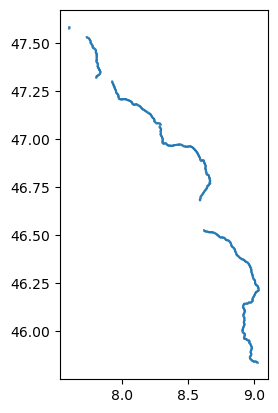

In [12]:
# PLOT FROM ORIGINAL GEOMETRY
print(len(motorways[motorways["ref"] == "A2"]))
motorways[motorways["ref"] == "A2"].plot()

MotorwayLine "1" has "17254" segments, and "34508" points.
The old line had 34508 points, now we only have 17259.
Bounding box with lower-left Point(x=2494780.692972598, y=1111906.9172627982) and upper-right Point(x=2766872.006168432, y=1265508.9340476028)


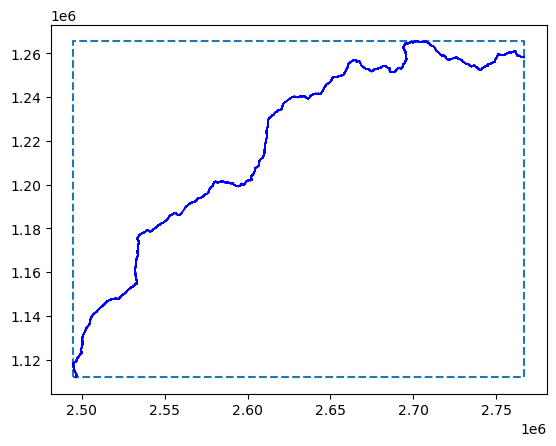

In [13]:
# PLOT A2
print(motorway_osm_lines[0])
motorway_osm_lines[0].removeDuplicates()
motorway_osm_lines[0].plot_bbox()
motorway_osm_lines[0].plot_seg()

## Swissdataset: Astra national roads

### Download data
Download data from:  
https://data.geo.admin.ch/browser/index.html#/collections/ch.astra.nationalstrassenachsen/items/nationalstrassenachsen?.language=en&.asset=asset-nationalstrassenachsen_2056.gdb.zip 


<AxesSubplot:>

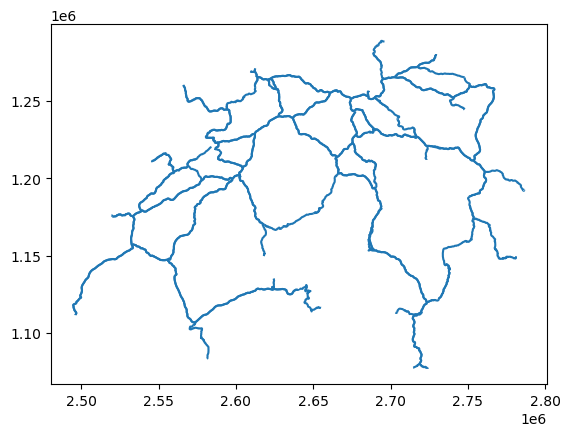

In [14]:
#import .gdb
import fiona
fiona.listlayers(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"))
motorways_ch = gpd.read_file(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"), driver='FileGDB', layer='Stammachsen')
motorways_ch.plot()

In [15]:
#visualize first 3 rows
motorways_ch[0:3]

,ID,Eigentuemer,Segmentname,Strassennummer,Bezeichnung,Positionscode,SHAPE_Length,geometry
0,{CFE92388-BFC8-4BE9-ACA6-77B507A0ECBA},CH,3. Röhre Belchen,N2BEL,N2 3. Röhre Belchen,=,3523.150899,MULTILINESTRING Z ((2628517.644 1247691.706 0....
1,{84E9F264-BD08-4293-9A70-130000145312},CH,ZÜRICH-NORD - Kloten-Süd,N11,Zürich - Kloten,+,3608.788116,MULTILINESTRING Z ((2685576.594 1253439.725 42...
2,{AA4CFACD-7C6E-4BB3-A789-1954D7D3162D},CH,Angenstein - Basel,N18,Delémont - Basel,+,7173.420712,MULTILINESTRING Z ((2612371.830 1258978.196 0....


### Data filtering
The federal roads office ASTRA [[1]](https://www.astra.admin.ch/astra/fr/home/themes/routes-nationales/reseau.html) is responsible for the national roads, i.e. the most important roads for Switzerland. Therefore ASTRA datasets do not only include highways, but also main roads.   
To sort national roads, a visual inspection of both datasets (OSM and ASTRA) was made on QGIS. This helped discovering that one of the attributes in ASTRA dataset could be used as a filter:
- Positionscode "=".  
"=" indicates that this is a one way road, which correlates with not being a highway, therefore not present in OSM dataset with the tag "highway".  
8 national roads were removed entirely this way (N1BAR, N2BEL, N2P, N17, N24, N25, N28 and N29).
Excepted for N24 (feeder road), which was removed even though it was also on OSM, this proved to be an efficient and quick filter.  
Out of 28 national roads, 20 then remained.

In addition, to crossvalidate the results, the following ressources have been used:  
- [autobahnen.ch](https://www.autobahnen.ch/).
- [Wiki page: List of the swiss national roads](https://de.wikipedia.org/wiki/Liste_der_Nationalstrassen_der_Schweiz)
- [Wiki page: List of the swiss highways and motorroads](https://de.wikipedia.org/wiki/Liste_der_Autobahnen_und_Autostrassen_in_der_Schweiz)

Astra dataset is unfortunately poorly documented online, therefore wikipedia was a useful source.

[[1]]: https://www.astra.admin.ch/astra/fr/home/themes/routes-nationales/reseau.html

In [16]:
#Remove positionscode =
filt_equal = motorways_ch["Positionscode"] != "="
motorways_ch = motorways_ch[filt_equal]
motorways_ch[0:3]

,ID,Eigentuemer,Segmentname,Strassennummer,Bezeichnung,Positionscode,SHAPE_Length,geometry
1,{84E9F264-BD08-4293-9A70-130000145312},CH,ZÜRICH-NORD - Kloten-Süd,N11,Zürich - Kloten,+,3608.788116,MULTILINESTRING Z ((2685576.594 1253439.725 42...
2,{AA4CFACD-7C6E-4BB3-A789-1954D7D3162D},CH,Angenstein - Basel,N18,Delémont - Basel,+,7173.420712,MULTILINESTRING Z ((2612371.830 1258978.196 0....
3,{E3F350B9-C4DC-4640-92A9-ACD40E3D0BF6},CH,Angenstein - Basel,N18,Delémont - Basel,-,7183.502921,MULTILINESTRING Z ((2612369.777 1258977.982 0....


### Renaming of the roads
National roads numbers (N1 -> N...) correspond with highways numbers (A1 -> A...), therefore the renaming contained only the number.

In [17]:
motorways_ch['streetname'] = motorways_ch['Strassennummer'].str.extract(r'(\d+)')
motorways_ch['streetname'] = pd.to_numeric(motorways_ch['streetname'])

streetnames_ch = motorways_ch['streetname'].unique()
print(sorted(streetnames_ch))
print(len(streetnames_ch))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23]
20


C:\Users\KikyoDLuffy\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Class MotorwaySegment

In [18]:
#extract geometries
print(motorways_ch["geometry"].geom_type.unique())
mway_ch_geometries = motorways_ch.geometry

#convert multilines to line
mway_ch_geometries_exp = mway_ch_geometries.explode(index_parts=True)
mway_ch_geometries_exp

['MultiLineString']


1    0    LINESTRING Z (2685576.594 1253439.725 424.735,...
2    0    LINESTRING Z (2612371.830 1258978.196 0.000, 2...
3    0    LINESTRING Z (2612369.777 1258977.982 0.000, 2...
4    0    LINESTRING Z (2623239.356 1259010.510 0.000, 2...
5    0    LINESTRING Z (2620905.722 1263783.033 0.000, 2...
                                ...                        
159  0    LINESTRING Z (2618735.040 1169909.530 0.000, 2...
160  0    LINESTRING Z (2627661.910 1167992.480 0.000, 2...
161  0    LINESTRING Z (2664221.400 1201220.141 436.160,...
162  0    LINESTRING Z (2630622.350 1168868.650 0.000, 2...
163  0    LINESTRING Z (2677815.381 1227877.377 428.230,...
Name: geometry, Length: 122, dtype: geometry

In [19]:
nested_coords_ch = [linestring_to_coords(line_geom) for line_geom in mway_ch_geometries_exp if type(line_geom)==type(LineString())]
nested_points_ch = [coords_to_point_list(coord_list) for coord_list in nested_coords_ch]
motorways_ch["points"] = nested_points_ch

C:\Users\KikyoDLuffy\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [20]:
#create the Segments dataset from the datasets
motorway_ch_segments = []
for index, row in motorways_ch.iterrows():
    origin_name = row['Strassennummer']
    name = row['streetname']
    points = row['points']
    for i in range(len(points)-1):
        start = points[i]
        end = points[i+1]
        source = "astra"
        crs = 'epsg:2056'
        segment = MotorwaySegment(start, end, name, origin_name, source, crs)
        motorway_ch_segments.append(segment)

### Class MotorwayLine

In [21]:
motorway_ch_lines = []
for streetname in streetnames_ch:
    list_segments = []
    for segment in motorway_ch_segments:
        #find all segments of the streetname and put them in a list
        if segment.name == streetname:
            list_segments.append(segment)
    #create the line from the list
    motorwayLine = MotorwayLine(list_segments)
    #add the street to the motorway_ch_lines dataset
    motorway_ch_lines.append(motorwayLine)    

#sort by order
motorway_ch_lines = sorted(motorway_ch_lines, key=lambda x: x.name)

print(motorway_ch_lines[0])
print(motorway_ch_lines[0].segments[0].origin_name)
len(motorway_ch_lines)

MotorwayLine "1" has "22748" segments, and "45496" points.
N1


20

### Data exploration

In [22]:
for motorway in motorway_ch_lines:
    if motorway.name == 2:
        N2 = motorway

N2.segments[0:10]

[MotorwaySegment of "2" with start Point(x=2636613.189086914, y=1239075.271118164) and end Point(x=2636665.1467285156, y=1239031.8137207031).,
 MotorwaySegment of "2" with start Point(x=2636665.1467285156, y=1239031.8137207031) and end Point(x=2636691.6049194336, y=1239009.3242797852).,
 MotorwaySegment of "2" with start Point(x=2636691.6049194336, y=1239009.3242797852) and end Point(x=2636719.519104004, y=1238985.6436767578).,
 MotorwaySegment of "2" with start Point(x=2636719.519104004, y=1238985.6436767578) and end Point(x=2636740.950317383, y=1238966.7265014648).,
 MotorwaySegment of "2" with start Point(x=2636740.950317383, y=1238966.7265014648) and end Point(x=2636765.688293457, y=1238943.9721069336).,
 MotorwaySegment of "2" with start Point(x=2636765.688293457, y=1238943.9721069336) and end Point(x=2636785.3994750977, y=1238924.7907104492).,
 MotorwaySegment of "2" with start Point(x=2636785.3994750977, y=1238924.7907104492) and end Point(x=2636809.6094970703, y=1238900.1843261

8


<AxesSubplot:>

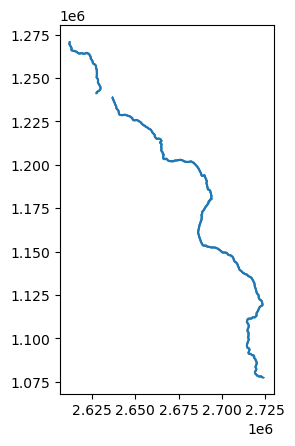

In [23]:
# PLOT A2 FROM ORIGINAL GEOMETRY
print(len(motorways_ch[motorways_ch["Strassennummer"] == "N2"]))
motorways_ch[motorways_ch["Strassennummer"] == "N2"].plot()

MotorwayLine "2" has "17396" segments, and "34792" points.
The old line had 34792 points, now we only have 17086.
Bounding box with lower-left Point(x=2612063.33392334, y=1077604.9141235352) and upper-right Point(x=2724111.5220947266, y=1271123.8577270508)


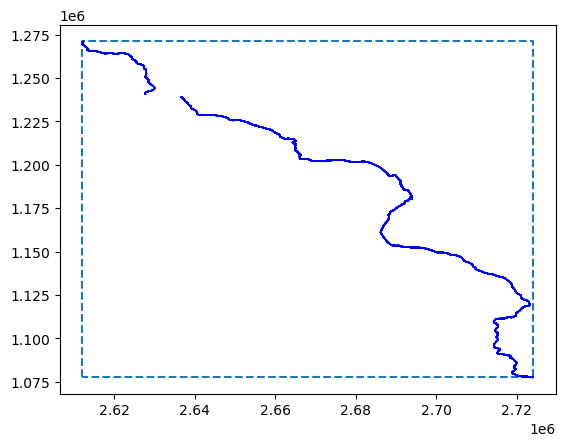

In [24]:
# PLOT A2 FROM MOTORWAY LINES
print(N2)
N2.removeDuplicates()
N2.plot_bbox()
N2.plot_seg()

## Datasets comparison

In [25]:
print(sorted(streetnames_osm))
print(sorted(streetnames_ch))
print(len(streetnames_osm))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23]
20


### Comparison of the motorway lines

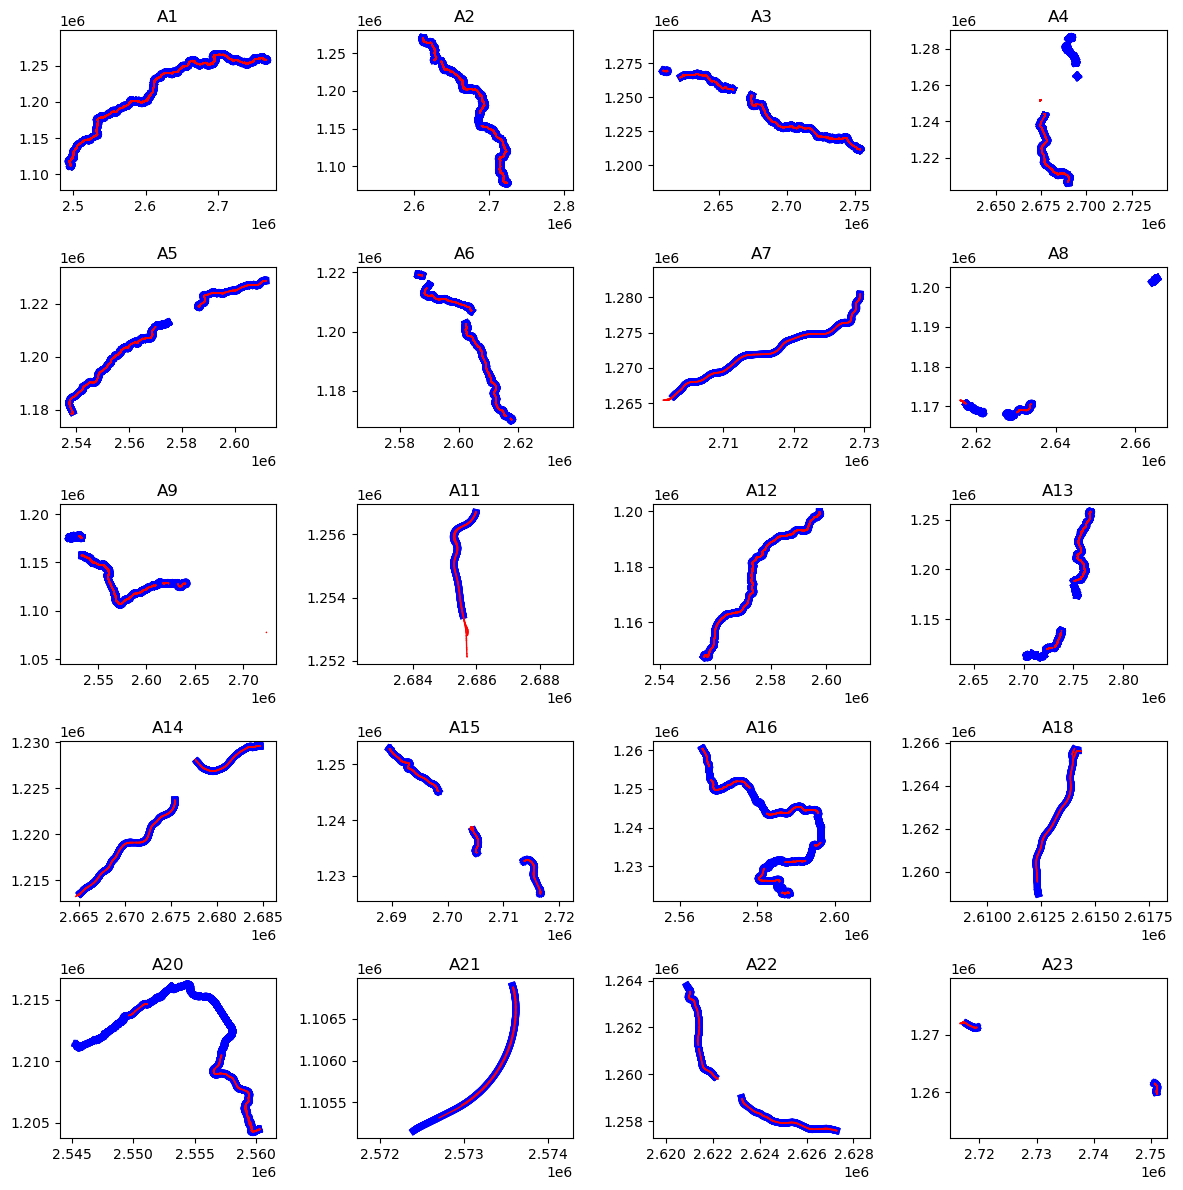

In [32]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
for i in range(5): #5
    for j in range(4): #4
        index = i * 4 + j
        motorway_ch_lines[index].plot_seg(ax = axs[i, j], label="ASTRA", color = "blue", linewidth = 5)
        motorway_osm_lines[index].plot_seg(ax = axs[i, j], label="OSM", color = "red")
        axs[i, j].set_title(f'A{motorway_osm_lines[index].name}')
        axs[i,j].set_aspect('equal', adjustable='datalim')

# Affichage de la figure
plt.tight_layout()
plt.show()
fig.savefig("plots/osm_astra_comparison.png")